# Stochastic processes and equilibrium


## The Langevin equation

When considering Brownian motion in continuous time and space, a very useful physical model is provided by the *Langevin equation*. This is a **stochastic differential equation** that includes deterministic and random forces to represent the motion of a particle suspended in a viscous fluid:

$$\begin{equation}
m \frac{d \vec{v}}{d t}=-\xi \vec{v}+\vec{F}_{ext}+\vec{\theta}(t) \\
\end{equation}
$$(langevin)


It states that the acceleration on the particle is determined by three contributions:
- a frictional force with macroscopic friction coefficient $\xi$ 
- an external force acting on the particle (e.g. an electric field, the force of gravity, etc.)
- a microscopic stochastic force \vec{\theta}$  defined by its first and second moments:

$$
\begin{aligned}
& \langle\vec{\theta}(t)\rangle=\overrightarrow{0} \\
& \left\langle\theta_{\alpha}(t) \theta_{\beta}\left(t^{\prime}\right)\right\rangle=2 \theta_{0} \delta_{\alpha \beta} \delta\left(t-t^{\prime}\right)
\end{aligned}
$$

The Langevin equation acts as a prototype for stochastic processes and allows us to explore various regimes.


### Free particle and fluctuation-dissipation relation


The first interesting  problem to address is the solution of the Langevin equation in the absence of external forces $F_{\rm ext}=0$.

$$\begin{equation}
m \frac{d \vec{v}}{d t}=-\xi \vec{v}+\vec{\theta}(t) \\
\end{equation}
$$(langevin)

The formal solution for a **free particle** (see Proof below) is

$$
\begin{equation}
\vec{v}(t)=e^{-\xi t/ m } \vec{v}(0)+\frac{1}{m} \int_{0}^{t} d s e^{-\xi (t-s)/m} \vec{\theta}(s)
\end{equation}
$$(free-langevin)


```{admonition} Proof
:class: proof dropdown

Since the particle is free

$$
\begin{equation}
\vec{F}_{\text {ext }}=\overrightarrow{0}
\end{equation}
$$

The Langevin equation eq.{eq}`langevin` reads 

$$\begin{equation}
\frac{d \bar{v}}{d t}=-\frac{\xi}{m} \vec{v}+\frac{1}{m} \vec{\theta}(t)
\end{equation}
$$

We treat this as a *stochastic differential equation*

$$
\begin{equation}
\begin{aligned}
& \frac{d x}{d t}=a x(t)+b(t) \\
& x(t)=e^{a t} y(t) \\
& a e^{a t} y(t)+e^{a t} \frac{d y}{d t}=a e^{a t} y(t)+b(t) \\
& \frac{d y}{d t}=e^{-a t} b(t) \\
& y(t)=\underbrace{y(0)}_{x(0)}+\int_0^t d s e^{-a s} b(s)
\end{aligned}
\end{equation}
$$

So 

$$
\begin{equation}
x(t)=e^{a t} x(0)+\int_0^t ds e^{-a(s-t)} b(s)
\end{equation}
$$

with

$$
\begin{equation}
a=-\frac{\xi}{m} \quad b=\frac{1}{m} \vec{\theta}
\end{equation}
$$

leading to 

$$
\begin{equation}
\vec{v}(t)=e^{-\xi / m t} \vec{v}(0)+\frac{1}{m} \int_{0}^{t} ds e^{-\xi / m(t-s)} \vec{\theta}(s)
\end{equation}
$$


```

It has two main ingredients:
- a **frictional damping** of the initial velocity due to the friction, which eventually vanishes to zero (the particle *forgets* about its initial velocity)
- a **time integral** over the impulses received from the random force (the particle is constantly kicked in different directions and with different kick strengths).

A single realisation of the dynamics in Eq.{eq}`free-langevin` is as informative as a single random walker: its velocity at time $t$ depends specifically on the sequence fo steps that we have followed.

We can see this by solving numerical the equation using the simplest scheme, the **Euler-Maruyama** scheme: the particle velocities are updated after a (small compared to time-units set by the mass and the friction coefficient) time-step according to 

$$\begin{equation}
v_{t+\Delta t} = v_t - \dfrac{\xi}{m} v_t \Delta t+\dfrac{1}{m} \sqrt{2\theta_0\Delta t}
\end{equation}
$$

Notice how the random force contribution is calculated: the stochastic kicks are producing a random walk in velocity space, so their variance scales linearly with the timestep, so that the force itself scales as the **square root** of the timestep. 

In [5]:
import numpy as np
import matplotlib.pyplot as plt

In [6]:
import numba


@numba.njit()
def free_particle_analytical(v0, xi, theta0, steps, dt, m, seed):
    """Calculate the discretised integral for the analytical solution for a free particle."""

    np.random.seed(seed)
    thetas = np.random.normal(0, np.sqrt(2 * theta0), steps)
    t = np.arange(steps) * dt
    ds = dt
    s = np.copy(t)
    integral = np.zeros(steps)
    for i in range(steps):
        integral[i] = np.sum(
            np.exp(-xi * (t[i] - s[:i]) / m)
            * thetas[:i]
            * np.sqrt(ds)  # note that the time discretisation has a step of sqrt(dt)
        )
    return t, v0 * np.exp(-xi * t / m) + integral / m


@numba.njit()
def free_particle_sim(v0, xi, theta0, steps, dt=0.01, m=1, seed=10):
    """Implement Euler-Maruyama method for a free particle."""

    np.random.seed(seed)
    v = np.zeros(steps)
    thetas = np.random.normal(0, np.sqrt(2 * theta0), steps)
    v[0] = v0
    for step in range(steps - 1):
        v[step + 1] = v[step] - xi / m * v[step] * dt + np.sqrt(dt) * thetas[step] / m
    t = np.arange(steps) * dt

    return t, v

We can construct a convenient function to plot the results for different values of the timestep and friction.

In [7]:
def plot_free_particle(dt, xi, theta0=0.1):
    seed = 10
    m = 1
    t, vsim = free_particle_sim(1, xi, theta0, 100, dt=dt, seed=seed)
    t, vanalytical = free_particle_analytical(1, xi, theta0, 100, dt, m, seed)

    plt.figure(figsize=(4, 2))
    plt.plot(t, vsim, label="Simulation")
    plt.plot(t, vanalytical, label="Semi-Analytical")
    plt.xlabel("Time")
    plt.ylabel("Velocity")
    plt.legend()
    plt.show()

For small timesteps, the simulation fllows closely the (semi)-analytical result.

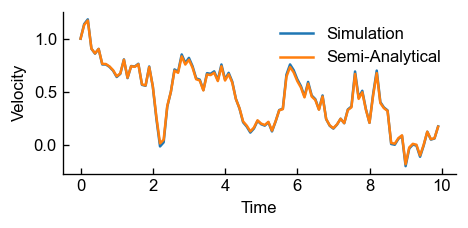

In [8]:
plot_free_particle(0.1, 0.5);

When the timestep is too large, the Euler-Maruyama solver is inaccurate.

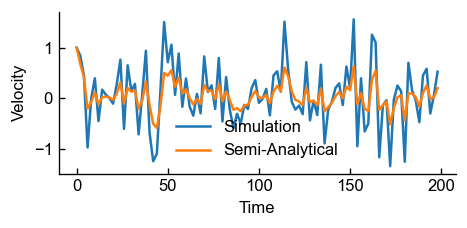

In [9]:
plot_free_particle(2.0, 0.5)

In an interactive session (e.g. `jupyter notebook`) you can run the following command to explore different regimes.

In [10]:
from ipywidgets import interact

interact(
    plot_free_particle, dt=(0.01, 2, 0.01), xi=(0.01, 1.5, 0.01), theta0=(0.0, 1.0, 0.1)
)

interactive(children=(FloatSlider(value=1.0, description='dt', max=2.0, min=0.01, step=0.01), FloatSlider(valu…

<function __main__.plot_free_particle(dt, xi, theta0=0.1)>

### Statistics of the velocity

Let us now look at some statistics at long time for the free particle.

#### Average velocity

At long times, the exponential term leads the system to forget its initial velocity with characteristic time $\tau=m/\xi$. What is left is the time integral of the stochastic force convoluted by the exponential weight. 

$$
\begin{equation}
\vec{v}(t)\xrightarrow{t\rightarrow\infty} \int_{0}^{t} ds e^{-\xi (t-s)/m} \vec{\theta}(s)
\end{equation}
$$

This is a new *stationary random process*, obtained as the sum (integral) over many individual processes whose average is zero. Therefore its average is zero

$$ \langle v(t)\rangle\rightarrow 0$$

We can easily test this

In [7]:
# we take a long simulation
t, vsim = free_particle_sim(1, 0.4, 0.2, 10000000, dt=0.01)
# we average over the last half of the arrays
print("Average velocity:", vsim[vsim.shape[0] // 2 :].mean())

Average velocity: 0.013530476068593379


We obtain a small number. But small *compared to what*?

#### Variance of the velocity

The appropriate comparison is provided by the standard deviation (i.e. the square root of the variance). Numerically

In [8]:
print("Standard deviation of the velocity:", vsim[vsim.shape[0] // 2 :].std())

Standard deviation of the velocity: 0.7004298977473117


This is a much larger value than the mean. But what determines it? Let us take first a numerical, exploratory look at the behaviour of the variance as we vary the stochastic force strength $\theta_0$ and the friction coefficient $\xi$. To do so, we wear our data-scientist hat and use datascience-oriented libraries such as `pandas` and `seaborn` for convenience.

In [9]:
import pandas as pd
import seaborn as sns

# sample a grid of xi and theta0 values
xi = np.linspace(0.1, 2, 20)
theta0 = np.linspace(0.01, 1.0, 10)
variances = {}
for _xi in xi:
    for _theta in theta0:
        t, v = free_particle_sim(1, _xi, _theta, 100000, dt=0.01)
        variances[(_xi, _theta)] = v[len(v) // 2 :].var()

We first plot the variances as a function of the oise strength $\theta_0$.

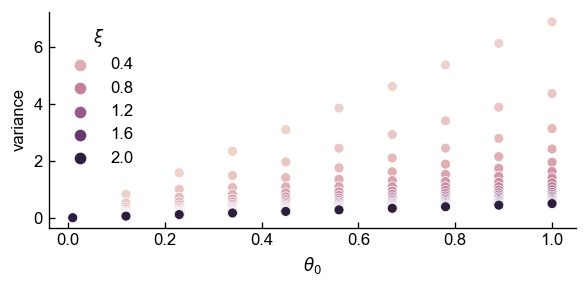

In [10]:
# construct a dataframe
v2dataframe = (
    pd.Series(variances)
    .rename_axis([r"$\xi$", r"$\theta_0$"])
    .reset_index(name="variance")
)
plt.figure(figsize=(5, 2.5))
sns.scatterplot(data=v2dataframe, hue=r"$\xi$", x=r"$\theta_0$", y="variance")
plt.show()

There is an interesting linear relation between the variance ${\rm Var}[v]=\langle v^2\rangle-\langle v\rangle^2=\langle v^2\rangle$ and $\theta_0$. A log-log plot gives us a sense of the scaling.

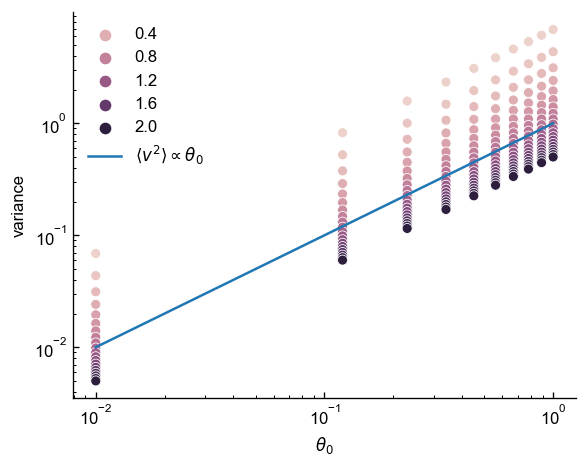

In [11]:
plt.figure(figsize=(5, 4))
sns.scatterplot(data=v2dataframe, hue=r"$\xi$", x=r"$\theta_0$", y="variance")
sns.lineplot(x=theta0, y=theta0, label=r"$\langle v^2\rangle\propto \theta_0$")
plt.yscale("log"), plt.xscale("log")
plt.show()

So,  we have that 

$$
\langle v^2\rangle\propto \theta_0.
$$

At the same time, the variance *decreases* with increasing $\xi$. This suggests an inverse relationship between the two that we can test numerically.

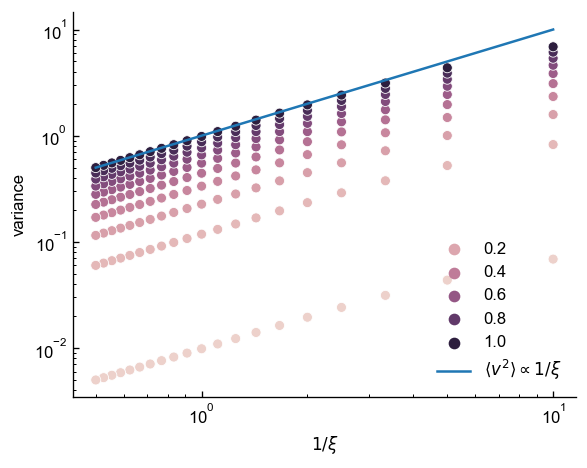

In [12]:
v2dataframe[r"$1/\xi$"] = 1 / v2dataframe[r"$\xi$"]
plt.figure(figsize=(5, 4))
sns.scatterplot(data=v2dataframe, hue=r"$\theta_0$", x=r"$1/\xi$", y="variance")
sns.lineplot(x=1 / xi, y=1 / xi, label=r"$\langle v^2\rangle\propto 1/\xi$")
plt.yscale("log"), plt.xscale("log")
plt.show()

Combining the two, we empirically have that

$$
\lim_{t\rightarrow\infty}\langle v^2\rangle\propto \theta_0/\xi
$$

Dimensional analysis can help us improve this guess as


````{margin}
```{note}
Check that the units of $\theta_0$ are $\dfrac{\mathsf{M}^2 \mathsf{L}^2}{\mathsf{T}^3}$
```
````
$$
[v^2]=\dfrac{\mathsf{L^2}}{\mathsf{T^2}} = [X] \dfrac{[\theta_0]}{[\xi]}=[X]\dfrac{\mathsf{M}^2 \mathsf{L}^2}{\mathsf{T}^3} \left(\dfrac{\mathsf{M}}{\mathsf{T}}\right)^{-1}
$$

Hence

$$[X] = 1/[m]$$

and 

$$
\lim_{t\rightarrow\infty}\langle v^2\rangle\propto \dfrac{\theta_0}{m\xi}
$$

A refined result can be obtained via an analytical calculation (see below) leading (in three dimensions) to

$$
\begin{equation}
\lim_{t\rightarrow\infty}\langle v^2\rangle=\frac{3 \theta_0}{\xi m}
\end{equation}
$$


```{admonition} Proof
:class: proof dropdown 

$$
\begin{align}
\langle| \vec{v}(t)|^2\rangle=\langle\vec{v}(t) \cdot \vec{v}(t)\rangle&=e^{-\frac{2 \xi}{m} t}\left\langle|\vec{v}(0)|^2\right\rangle+\\
&+\frac{2}{m} \int_{d s}^t d e^{-\frac{\xi}{m}(2 t-s)}+\\
&+\frac{1}{m^2} \int_0^t d s \int_0^t d s^{\prime} e^{-\xi / m\left(2 t-s-s^{\prime}\right)}\left\langle\vec{\theta}(s) \cdot \bar{\theta}\left(s^{\prime}\right)\right\rangle
\end{align}
$$

The last integral can be solved as 

$$\begin{align}
I &= \frac{1}{m^2} \int_0^t d s \int_0^t d s^{\prime} e^{-\xi / m\left(2 t-s-s^{\prime}\right)}\left\langle\vec{\theta}(s) \cdot \bar{\theta}\left(s^{\prime}\right)\right\rangle\\
&=\frac{1}{m^2} \int_0^t d s \int_0^t d s^{\prime} e^{-\xi / m\left(2 t-s^{\prime}-s^{\prime}\right)} 6 \theta_0 \delta\left(s-s^{\prime}\right)\\
&=\frac{6 \theta_0}{m^2} \int_0^t d s e^{-\frac{2 \xi}{m}(t-s)}
\end{align}
$$

Therefore

$$\begin{align}
\lim _{t \rightarrow \infty}\left\langle|\bar{v}(t)|^2\right\rangle&= \lim _{t \rightarrow \infty}e^{-\frac{2 \xi}{m} t}\left\langle|\bar{v}(0)|^2\right\rangle+\frac{6 \theta_0}{m^2} \int_0^{\infty} d s e^{-\frac{2 \xi}{m}(t-s)}\\
&=\lim _{t \rightarrow \infty} \frac{6 \theta_0}{m^2} \frac{m}{2 \xi}\left[e^{-\frac{2 \xi}{m}(t-s)}\right]_0^t\\
&= \lim _{t \rightarrow \infty}\frac{6 \theta_0}{m^2} \frac{m}{2 \xi}\left[1-e^{-\frac{2 \xi}{m} t}\right]\\
&= \frac{3 \theta_0}{\xi m}
\end{align}
$$


```

So:
- in general, given a process modelled by a Langevin equation, the stochastic force strength and the frictional force can be changed independently.
- however, the resulting variance of the stochastic velocity depends on both. If we have physical reasons to fix the variance, then the stochastic and frictional force are **no longer independent**.

Indeed, there is a a very profound result related to ergodicity and equilibrium that allows us to fix the variance of the velocity and relate the friction to the stochastic force strength.

### Fluctuation-dissipation

````{margin}
```{note}
Temperature enters the Langevin equation only when thermal equilibrium is assumed.
```
````

If a system is ergodic, it explores the phase space in a uniform manner. If it is in thermal equilibrium, it does so because it is in contact with a *heat bath* at temperature $T$.



Thermal equilibrium in an ergodic system further imposes that every energy level is equally populated . The [equipartition theorem](https://en.wikipedia.org/wiki/Equipartition_theorem) states then every quadratic term in the energy function (the Hamiltonian) contributes $\dfrac{1}{2} k_BT$ of energy.

Let us assume that the equilibrium velocity is $\langle|\vec{v}|\rangle=v_{\rm eq}$. For the kinetic energy this means that

$\dfrac{1}{2}m v_{\rm eq}^2 = \dfrac{3}{2}k_bT$

Our long-time variance can be identified with $v_{\rm eq}^2$ so that

$$
\lim _{t \rightarrow \infty}\left\langle|\vec{v}(t)|^2\right\rangle=\frac{3 \theta_0}{\xi m}= v^2_{\text {eq }}=3\dfrac{k_b}{m}T
$$

This immediately lead us to 
```{admonition} First fluctuation-dissipation relation
$$
\begin{equation}
\theta_0 = k_bT \xi
\end{equation}
$$
```
were $\theta_0$ quantifies the strength of the fluctuations, while $\xi$ is the strength of the dissipative forces.


### Velocity autocorrelation
So, at equilibrium the fluctuation of the velocity attain, at long times, a limit value that is controlled by the temperature and resulting from the balance between fluctuation and dissipation. How is this limit attained?

The **velocity autocorrelation** is defined as

$$
\begin{equation}
C_v\left(t^{\prime}, t^{\prime \prime}\right)=\left\langle\left(v\left(t^{\prime}\right)-\langle v\rangle\right)\left(v\left(t^{\prime \prime}\right)-\langle v\rangle\right)\right\rangle
\end{equation}
$$

We have seen that the long time average value is zero. Let's take a stationary process, so that we can consider, without loss of generality $t^\prime=0$ and $t^{\prime\prime}=t$.

$$
C_v(t)=\langle v(t) v(0)\rangle
$$

We can  interpret the $\langle\cdot\rangle$ sign in two ways:

- an average over many realisations
- an average over many different starting times

We can easily see that they match.

First we calculate the correlations from independent realisations, starting from an equilibrium velocity

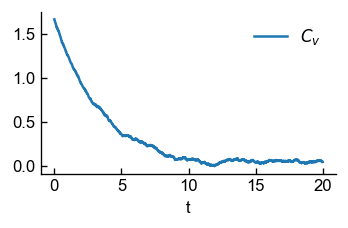

In [153]:
def cv_many_realisations(v0, xi, theta0, m, num_realisations, steps=2000, dt=0.01):
    """Compute the velocity correlation of a free particle under Langevin dynamics from independent realisations."""
    vs = []
    for k in range(num_realisations):
        t, v = free_particle_sim(v0, xi, theta0, steps, dt=dt, seed=k, m=m)
        vs.append(v[0] * v)
    vs = np.array(vs)
    return t, np.mean(vs, axis=0)


xi, theta0, m = 0.3, 0.5, 1.0
# we are at equilibrium, so v0**2 = theta0/xi= kT
v0 = np.sqrt(theta0 / xi)
dfmany = pd.DataFrame(
    np.column_stack(cv_many_realisations(v0, xi, theta0, m, num_realisations=2000)),
    columns=["t", "$C_v$"],
)

dfmany.plot(x="t", y="$C_v$", figsize=(3, 2))
pass

The alternative is to produce one single realisation of the dynamics that we sample at various intervals. There is here a delicate point that we will encounter also in the future: how much of an overlap can such intervals have? The free particle has a characteristic correlation time $\tau=m/\xi$. We can take multiples of $\tau$ to space this interval.

Correlation steps 333
Separation steps  333


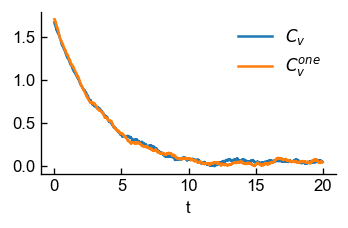

In [171]:
def cv_one_realisation(v0, xi, theta0, m, num_begin, dt=0.01, steps=2000, multiplier=1):
    """Compute the velocity correlation of a free particle under Langevin dynamics from a single realisation sampled at times spaced by cortime = int(m / xi / dt * multiplier) steps."""
    cortime = int(m / xi / dt)
    separation = int(cortime * multiplier)
    print("Correlation steps", cortime)
    print("Separation steps ", separation)
    runtime = int(num_begin * separation) + steps
    t, v = free_particle_sim(v0, xi, theta0, runtime, dt=dt, m=m)
    vs = np.array(
        [
            v[begin * separation : begin * separation + steps]
            for begin in range(num_begin)
        ]
    )
    vs = vs * vs[:, 0][:, np.newaxis]
    return t[:steps], np.mean(vs[:, :steps], axis=0)


dfone = pd.DataFrame(
    np.column_stack(
        cv_one_realisation(v0, xi, theta0, m, num_begin=2000, multiplier=1)
    ),
    columns=["t", r"$C_v^{one}$"],
)

ax = dfmany.plot(x="t", y="$C_v$", figsize=(3, 2))
plot = dfone.plot(x="t", y=r"$C_v^{one}$", ax=ax)

However, sampling too frequently picks up correlated samples, which do not produce the correct statistics of the autocorrelation function: 


Correlation steps 333
Separation steps  6
Correlation steps 333
Separation steps  16
Correlation steps 333
Separation steps  33
Correlation steps 333
Separation steps  166
Correlation steps 333
Separation steps  333


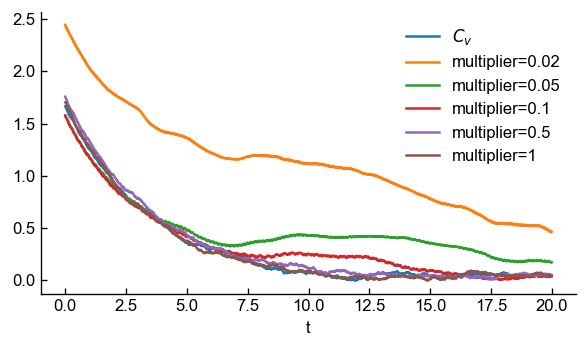

In [170]:
ax = dfmany.plot(x="t", y="$C_v$", figsize=(5, 3))

for multiplier in [0.02, 0.05, 0.1, 0.5, 1]:
    label = f"multiplier={multiplier}"
    dfone = pd.DataFrame(
        np.column_stack(
            cv_one_realisation(v0, xi, theta0, m, num_begin=2000, multiplier=multiplier)
        ),
        columns=["t", label],
    )
    plot = dfone.plot(x="t", y=label, ax=ax)

In [ ]:
# Model parameters
npart = 1000
ndims = 1
friction = 1.0
k = 0.5
T = 1.0
dt = 0.04
nsteps = int(30.0 / dt)

# Fluctuation dissipation relation
D = T / friction
width = (2 * D * dt) ** 0.5

# Overdamped Brownian dynamics
positions = numpy.zeros((npart, ndims))
msd = []
for i in range(nsteps):
    # Store MSD
    msd.append(numpy.sum(positions**2) / npart)

    # Integration step
    for position in positions:
        noise = numpy.random.normal(0.0, width, ndims)
        # No external field
        force = numpy.zeros(ndims)
        # Harmonic potential
        # force = - k * position
        position += noise + force * dt / friction

time = numpy.array(range(nsteps)) * dt
plt.plot(time, msd, "o", label="Simulation")
# Theoretical diffusive behavior (in the absence of external force)
plt.plot(time, 2 * ndims * D * time, "-", label="Theory")
# This is to plot an horizontal line at height y
# plt.axhline(y, xmin=time[0], xmax=time[-1])
plt.xlabel("t")
plt.ylabel("MSD")
plt.legend()

**Exercise 1**: *drift-diffusion*

The Brownian particles are subject to a constant external force $F>0$ in one dimension. This will lead to a systematic drift in the motion of the particles.

1. Compute analytically the first two moments of the position, $\langle x(t)\rangle$ and $\langle x^2(t)\rangle$, and provide a physical interpretation of the results
2. Cross-check the results against the simulation data and plot the results in a double logarithmic scale. Identify the ballistic and the diffusive regime.

**Exercise 2**: *harmonic potential* 

Put the Brownian particles in a harmonic potential $U(x) = \frac{1}{2}kx^2$ in one dimension.

1. Check that $\langle |\Delta x(t)|^2\rangle$ is diffusive in the absence of external field but saturates to a finite value when the harmonic potential is switched on

2. Determine analytically the equilibrium value $\langle |\Delta x(t=\infty)|^2\rangle$ and compare it to the simulation data. Which factors control the relaxation time that describes the approach to equilibrium? 

**Exercise 3**: *thermally activated barrier crossing*

Study numerically the dynamics of a Brownian particle in a one-dimensional double well potential 

$$
U(x) = U_0 (1 - (x/a)^2)^2
$$

The initial position of the particle will be at the bottom of the left well: $x(t=0)=-a$. 

1. Choose a temperature $T > U_0$, for which barrier crossing is easy, and plot a single trajectory $x(t)$ over a sufficiently long time. What do you observe?
2. Reduce the temperature, $T < U_0$, and repeat the numerical experiment. What do you observe? 
3. Give the expression of the probability density $p(x)$ at equilibrium. Can you estimate the time needed to reach equilibrium? (simulate several independent particles in parallel)

In [ ]:
# Model parameters
npart = 1
ndims = 1
friction = 1.0
k = 0.5
T = 0.2
dt = 0.01
nsteps = int(1000.0 / dt)
D = T / friction
width = (2 * D * dt) ** 0.5

# Overdamped Brownian dynamics
positions = numpy.zeros((npart, ndims))
pos = []
for i in range(nsteps):
    pos.append(position[0])  # numpy.sum(positions**2) / npart)
    for position in positions:
        noise = numpy.random.normal(0.0, width, ndims)
        # force = numpy.zeros(ndims)
        force = 4 * position * (1 - position**2)
        position += noise + force * dt / friction

time = numpy.array(range(nsteps)) * dt
plt.plot(time, pos, "o", label="Simulation")
plt.xlabel("t")

In [ ]:
# Double well potential
x = numpy.linspace(-1.5, 1.5, 100)
plt.plot(x, (1 - x**2) ** 2)

**Exercise 4**: *stochastic resonance*

Consider a Brownian particle in a double well potential
$$
U(x) = U_0 (1 - (x/a)^2)^2
$$
subject to an additional periodic force of the form
$$
F(x) = F_0 \sin(2\pi t/\tau)
$$
where $A$ is the forcing amplitude and $\tau$ is the forcing period. For convenience, set $U_0=1$ and $a=1$.

1. Use Kramers theory to estimate the relaxation time $\tau_K$ at $T=0.4$ *in the absence of forcing* ($A=0$).
2. Add a small forcing $F_0=10^{-1}$ and plot the trajectory of the Brownian particle $x(t)$ over a time much longer than $\tau_K$ in the following two cases: (i) $\tau > \tau_K$, (ii) $\tau < \tau_K$. What do you observe? 
3. Compare your results to the analysis of Benzi, Nonlin. Processes Geophys. 17, 431 (2010) (https://npg.copernicus.org/articles/17/431/2010/) and of Simon & Libchaber, Phys. Rev. Lett. 68, 3375 (1992) (https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.68.3375)

In [ ]:
import numpy
import matplotlib.pyplot as plt

# Model parameters
npart = 1
ndims = 1
friction = 1.0
k = 0.5
T = 0.4
dt = 0.04
nsteps = int(2000.0 / dt)
U_0 = 1
a = 1
A = 1e-1
tau = 100.0

# Fluctuation dissipation relation
D = T / friction
width = (2 * D * dt) ** 0.5

# Overdamped Brownian dynamics
positions = numpy.zeros((npart, ndims))
x = []
for i in range(nsteps):
    # Store MSD
    x.append(positions[0, 0])

    # Integration step
    for position in positions:
        noise = numpy.random.normal(0.0, width, ndims)
        # No external field
        force = numpy.zeros(ndims)
        # Harmonic potential
        force = 4 * U_0 / a**2 * position * (1 - (position / a) ** 2)
        force += A * numpy.sin(2 * numpy.pi * i * dt / tau)
        position += noise + force * dt / friction

time = numpy.array(range(nsteps)) * dt
plt.plot(time, x)
# This is to plot an horizontal line at height y
# plt.axhline(y, xmin=time[0], xmax=time[-1])
plt.xlabel("t")

In [ ]:
import matplotlib.pyplot as plt

plt.plot(msd_db.keys(), msd_db.values())